In [167]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import pandas as pd
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, Flatten, AveragePooling2D, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

In [152]:
# define which categories to predict
categories = ('normal', 'covid', 'bacteria', 'virus')

# initialize variables for storing images and their labels
labels = []
data = []

In [153]:
# for each category, browse folders
# each image shall be resized to 200x200
# load images images and labels to memory
for cat in categories:
    for path in os.listdir('datasets/' + cat + '/'):
        image = cv2.imread('datasets/' + cat + '/' + path)
        
        image = cv2.resize(image, (200, 200))

        data.append(image)
        labels.append(cat)

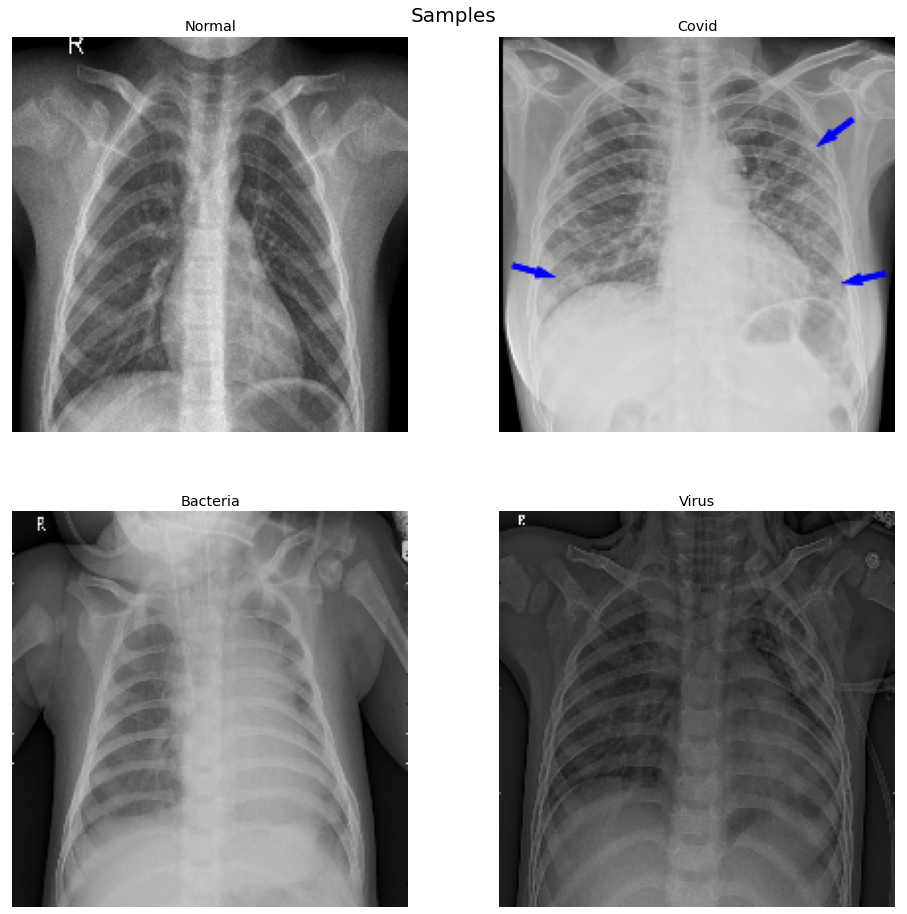

In [154]:
# define figure with 
fig = plt.figure(figsize=(16, 16))

# define title
plt.title('Samples', fontdict={'fontsize': 20}, pad=15)

# remove axis
plt.axis('off')

# take random image from each category dataset
# resize to 200x200
# append to the plot
for i, title in enumerate(categories):
    fig.add_subplot(2, 2, i + 1)
    plt.title(title.capitalize())
    plt.axis('off')
    img = cv2.imread('datasets/{}/{}'.format(title, random.sample(os.listdir('datasets/' + title), 1)[0]))
    img = cv2.resize(img, (200, 200))
    plt.imshow(img)

# show figure
plt.show()

In [155]:
# rescale pixels to range [0, 255]
# convert to numpy array
data = np.array(data) / 255.0
labels = np.array(labels)

# create label encoder
# transform to one hot encoded vector
# e.g. (label1, label2) -> ((1, 0), (0, 1))
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# split dataset into training and testing chunks
# test chunk is 20% from total dataset
train_x, test_x, train_y, test_y = train_test_split(data, labels, test_size=.2, stratify=labels)

# create image generator
# returns image only when it is needed, useful for memory optimization
# return augmented images, rotated randomly by 20 degrees
augmented = ImageDataGenerator(rotation_range=20, fill_mode='nearest')

In [156]:
def get_model(imp=False):
    """
    function to create model or load from local memory
    
    :param imp: True/False, if True, loads model from memory 
    :return: keras model
    """
    
    # if imp, load model from local memory and return
    if imp:
        return load_model('model.h5')
    
    # use VGG16 from pretrained models as base model for our model
    # change input layer according to our image shape
    # (200, 200, 3) -> 200x200 image with 3 channels
    base = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(200, 200, 3)))
    
    # restrict base model layers to be trained
    for layer in base.layers:
        layer.trainable = False
    
    # append more layers to base model
    model = base.output
    model = AveragePooling2D(pool_size=(4, 4))(model)
    model = Flatten()(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    
    # create output layer with 4 neurons
    # according to quantity of categories
    model = Dense(4, activation='softmax')(model)
    
    # create new model by blending base model with our model
    model = Model(inputs=base.input, outputs=model)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [157]:
# get model
model = get_model(True)

In [158]:
# print model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [103]:
# train model
# pass created above generator with training datasets
# pass validation datasets
# pass number of epochs
fit_results = model.fit(augmented.flow(train_x, train_y, batch_size=64), validation_data=(test_x, test_y), epochs=20)

Train for 7 steps, validate on 103 samples
Epoch 1/20
7/7 [==============================] - 137s 20s/step - loss: 0.5450 - accuracy: 0.8264 - val_loss: 0.4138 - val_accuracy: 0.8738
Epoch 2/20
7/7 [==============================] - 125s 18s/step - loss: 0.5729 - accuracy: 0.8068 - val_loss: 0.4084 - val_accuracy: 0.8738
Epoch 3/20
7/7 [==============================] - 123s 18s/step - loss: 0.5431 - accuracy: 0.7922 - val_loss: 0.4121 - val_accuracy: 0.8738
Epoch 4/20
7/7 [==============================] - 124s 18s/step - loss: 0.5269 - accuracy: 0.8289 - val_loss: 0.4132 - val_accuracy: 0.8641
Epoch 5/20
7/7 [==============================] - 128s 18s/step - loss: 0.5157 - accuracy: 0.8533 - val_loss: 0.4108 - val_accuracy: 0.8641
Epoch 6/20
7/7 [==============================] - 134s 19s/step - loss: 0.5066 - accuracy: 0.8093 - val_loss: 0.4124 - val_accuracy: 0.8738
Epoch 7/20
7/7 [==============================] - 131s 19s/step - loss: 0.5163 - accuracy: 0.8191 - val_loss: 0.4094 

In [104]:
# save model to local storage
model.save('model.h5', save_format='h5')

In [105]:
# predict from validation dataset
predicted = model.predict(test_x, batch_size=64)

In [173]:
# create lists of loss and accuracy values, saved between training sessions
# sessions were conducted with time breaks
# that is why, I've saved results manually

loss = np.array([
    139, 131, 129, 127, 122, 121, 115, 115, 107, 109, 104, 101, 100, 99, 96, 92, 93, 89, 87, 86,
    84, 83, 82, 79, 77, 78, 75, 75, 70, 72, 71, 70, 69, 71, 65, 66, 64, 66, 62, 61,
    64, 64, 65, 65, 59, 62, 64, 60, 56, 58, 57, 55, 57, 54, 54, 55, 57, 55, 52, 55,
    54, 57, 54, 52, 51, 50, 51, 56, 51, 51, 53, 54, 52, 49, 51, 49, 52, 51 ,48, 46,
])

accuracy = np.array([
    30, 38, 36, 42, 51, 51, 57, 55, 58, 56, 63, 62, 64, 62, 66, 65, 65, 69, 69, 70,
    67, 69, 71, 72, 73, 72, 71, 72, 78, 75, 73, 74, 72, 75, 78, 76, 77, 73, 79, 79,
    73, 74, 75, 77, 77, 75, 74, 78, 79, 78, 79, 78, 78, 81, 80, 78, 76, 80, 81, 79,
    82, 80, 79, 82, 85, 80, 81, 78, 82, 79, 81, 78, 82, 80, 83, 82, 83, 82, 83, 84,
])

# total 4 sessions with total of 80 epochs
epochs = list(range(1, 81))

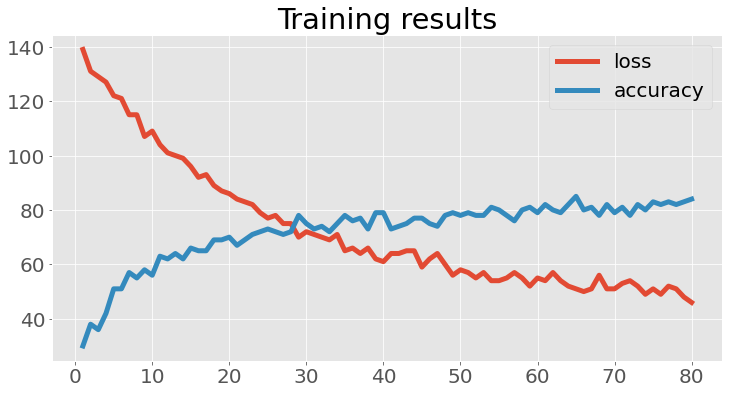

In [185]:
# create and show graph with train loss values for 80 epochs
df = pd.DataFrame({'x': epochs, 'loss': loss, 'accuracy': accuracy})
plt.figure(figsize=(12, 6))
plt.plot('x', 'loss', data=df, linewidth=5)
plt.plot('x', 'accuracy', data=df, linewidth=5)
plt.title('Training results')
plt.rc('font', size=20)
plt.legend()
plt.show()

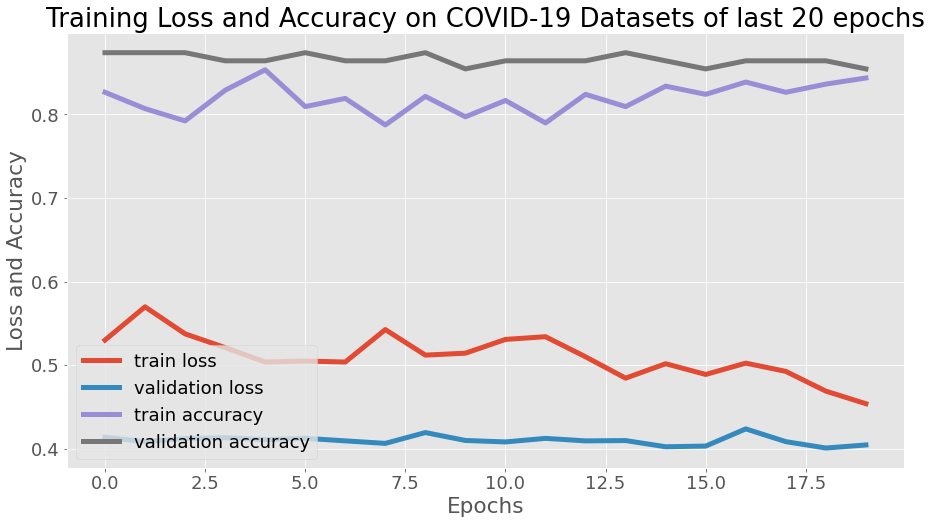

In [188]:
# create graph from results of last 20 epochs
# it shows results of train loss and validation loss, train accuracy and validation accuracy
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, 20), fit_results.history["loss"], label="train loss", linewidth=5)
plt.plot(np.arange(0, 20), fit_results.history["val_loss"], label="validation loss", linewidth=5)
plt.plot(np.arange(0, 20), fit_results.history["accuracy"], label="train accuracy", linewidth=5)
plt.plot(np.arange(0, 20), fit_results.history["val_accuracy"], label="validation accuracy", linewidth=5)
plt.title("Training Loss and Accuracy on COVID-19 Datasets of last 20 epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.rc('font', size=18)
plt.legend(loc="lower left")
plt.show()